In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
crack_images_name_list = os.listdir('dataset/train/crack/')
noncrack_images_name_list = os.listdir('dataset/train/non-crack/')

In [3]:
noncrack_images_name_list.remove('labels.txt')

In [4]:
image_width = 256
image_heigth = 256

In [5]:
crack_images_list = []
for image_name in crack_images_name_list:
    im = cv2.imread('dataset/train/crack/'+ image_name)
    im_color = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_resized = cv2.resize(im_color, (image_width, image_heigth))
    im_blur = cv2.medianBlur(im_resized, 3)
    crack_images_list.append(im_resized)
    
noncrack_images_list = []
for image_name in noncrack_images_name_list:
    im = cv2.imread('dataset/train/non-crack/'+ image_name, cv2.IMREAD_GRAYSCALE)
    im_color = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_resized = cv2.resize(im_color, (image_width, image_heigth))
    im_blur = cv2.medianBlur(im_resized, 3)
    noncrack_images_list.append(im_resized)

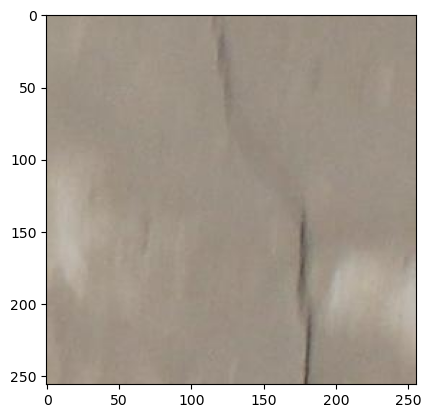

In [6]:
plt.imshow(crack_images_list[3])

In [8]:
def converter_RGB_para_HSI(image_matrix):
  #image_matrix = np.array(imagem)
  altura, largura = image_matrix.shape[:2]
  image_matrix_red = image_matrix[:, :, 0]
  image_matrix_green = image_matrix[:, :, 1]
  image_matrix_blue = image_matrix[:, :, 2]

  i_matrix = np.zeros((altura, largura))
  s_matrix = np.zeros((altura, largura))
  h_matrix = np.zeros((altura, largura))

  for y in range(altura):
    for x in range(largura):
      r = image_matrix_red[x][y]
      g = image_matrix_green[x][y]
      b = image_matrix_blue[x][y]

      r_norm = r / 255
      g_norm = g / 255
      b_norm = b / 255

      i = (r_norm + g_norm + b_norm) / 3

      min_val = min(r_norm, g_norm, b_norm)

      if i == 0:
        s == 0
      else:
        s = 1 - (min_val / i)

      num = 0.5*((r_norm-g_norm)+(r_norm-b_norm))
      den = np.sqrt(abs(r_norm**2 + g_norm**2 + b_norm**2 - r_norm*g_norm - r_norm*b_norm - g_norm*b_norm)) + 0.0001

      division = min(max(num/den, -1), 1)

      h = np.arccos(division)

      if b_norm > g_norm:
        h = 2 * np.pi - h

      i_matrix[x][y] = i
      s_matrix[x][y] = s
      h_matrix[x][y] = h

  return h_matrix, s_matrix, i_matrix

In [9]:
images_hsi = []
for image in crack_images_list:
    image_matrix = np.array(image)
    h_matrix, s_matrix, i_matrix = converter_RGB_para_HSI(image_matrix)
    images_hsi.append([h_matrix, s_matrix, i_matrix])

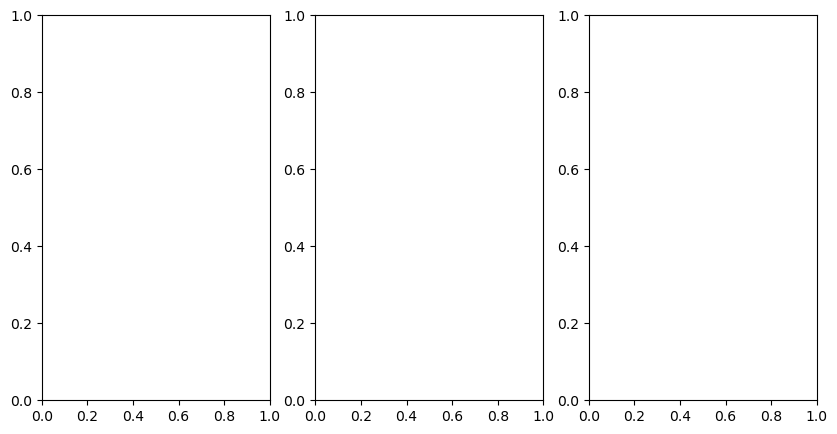

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cv2.imshow('Hue', (images_hsi[3][0] / (2 * np.pi)).astype(np.uint8))
cv2.imshow('Saturation', (images_hsi[3][1] * 255).astype(np.uint8))
cv2.imshow('Intensity', (images_hsi[3][2] * 255).astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()
#axes[0].imshow((images_hsi[1][0] / (2 * np.pi)).astype(np.uint8), cmap='gray')
#axes[1].imshow((images_hsi[1][1] * 255).astype(np.uint8), cmap='gray')
#axes[2].imshow((images_hsi[1][2] * 255).astype(np.uint8), cmap='gray')

In [74]:
# OTSU THRESHOLD
thresholded_crack_images = []
for image in crack_images_list:
    ret, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresholded_crack_images.append(thresholded)

In [77]:
def save_single_channel_processed_images_for_comparison(original_images_list, original_images_names_list, \
                                                        processed_images_with_single_channel, \
                                                        directory_to_save):
    height = original_images_list[0].shape[0]
    width = original_images_list[0].shape[1]
    
    for idx in range(len(original_images_names_list)):
        
        collage_width = original_images_list[idx].shape[1] * 2
        collage = np.ones((height, collage_width), np.uint8) * 255
        collage = cv2.resize(collage, (collage_width, height))
        
        collage[:, :original_images_list[idx].shape[1]] = original_images_list[idx]
        collage[:, original_images_list[idx].shape[1]:] = processed_images_with_single_channel[idx]
        
        if not os.path.exists('processed-dataset-tests/' + directory_to_save):
            os.makedirs('processed-dataset-tests/' + directory_to_save)
        cv2.imwrite('processed-dataset-tests/' + directory_to_save + '/' + original_images_names_list[idx], collage)

In [78]:
save_single_channel_processed_images_for_comparison(crack_images_list, \
                                                    crack_images_name_list, \
                                                    thresholded_crack_images, \
                                                    'only-otsu')

In [82]:
# SOBEL OPERATOR
sobel_images = []
canny_images = []
for image in crack_images_list:
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)
    
    sobel_images.append(gradient_magnitude)
    
    canny_edges = cv2.Canny(gradient_magnitude, threshold1=50, threshold2=150)
    
    canny_images.append(canny_edges)

In [83]:
save_single_channel_processed_images_for_comparison(crack_images_list, \
                                                    crack_images_name_list, \
                                                    sobel_images, \
                                                    'only-sobel')

In [85]:
save_single_channel_processed_images_for_comparison(crack_images_list, \
                                                    crack_images_name_list, \
                                                    canny_images, \
                                                    'only-canny')

In [87]:
# SOBEL + OTSU THRESHOLD
sobel_otsu_crack_images = []
for image in sobel_images:
    ret, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    sobel_otsu_crack_images.append(thresholded)

In [88]:
save_single_channel_processed_images_for_comparison(crack_images_list, \
                                                    crack_images_name_list, \
                                                    sobel_otsu_crack_images, \
                                                    'sobel-and-otsu')

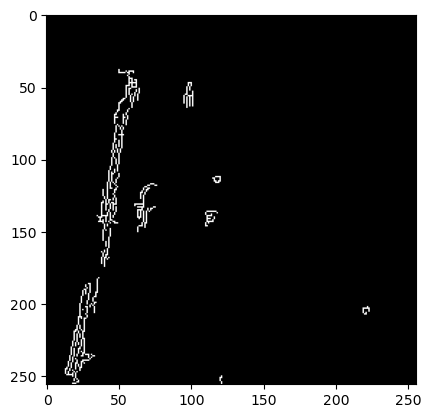

In [81]:
plt.imshow(sobel_images[1], cmap='gray')